## Importing DataSet

In [20]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

class HeartRateDataset(Dataset):
    def __init__(self, data_path, frame_length, pixel_size):
        self.data_path = data_path
        self.frame_length = frame_length
        self.pixel_size = pixel_size
        self.video_paths, self.labels = self._read_data()

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, index):
        self.index = index
        video_path = self.video_paths[index]
        label = self.labels[index]
        # print(video_path, index, label)
        clips, clips_labels = self._load_video(video_path, label)
        return clips, clips_labels

    def _read_data(self):
        video_paths = []
        labels = []
        for root, _, files in os.walk(self.data_path):
          if "vid.avi" in files and "ground_truth.txt" in files:
              video_path = os.path.join(root, "vid.avi")
              ground_truth_file = os.path.join(root, "ground_truth.txt")
              with open(ground_truth_file, 'r') as f:
                  # Read the first two lines
                  lines = f.readlines()
                  if len(lines) >= 2:
                      # Split the second line into numerical values
                      label_line = lines[1].strip()
                      label_values = [float(val) for val in label_line.split()]
                      video_paths.append(video_path)
                      labels.append(label_values)
                  else:
                      print(f"Skipping {video_path} due to missing second line in ground_truth.txt")
        return video_paths, labels


    def _load_video(self, video_path, label):
        cap = cv2.VideoCapture(video_path)
        video_frames = []
        frame_indices = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            # plt.subplot(3,3,ret);plt.imshow(frame)
            if not ret:
                break
            video_frames.append(frame)
            frame_indices.append(frame_count)
            frame_count += 1
            # plt.subplot(50,50,frame_count);plt.imshow(frame)
        cap.release()

        # print(frame_indices)
        # Randomly choose 16 frame indices
        selected_indices = np.random.choice(frame_indices, size=self.frame_length, replace=False)

        # Convert labels to a NumPy array
        labels_array = np.array(label)

        # Use the selected indices to retrieve corresponding heart rate labels
        selected_labels = labels_array[selected_indices]  # Select the appropriate columns

        selected_frames = [video_frames[i] for i in selected_indices]
        selected_frames = self._preprocess_frames(selected_frames)
        video_tensor = torch.tensor(selected_frames)  # Convert NumPy array to PyTorch tensor
        # self._imshow_frames(selected_frames)


        if len(video_tensor) < self.frame_length:
          num_repeats = self.frame_length // len(video_tensor) + 1
          video_tensor = video_tensor.repeat(num_repeats, 1, 1, 1)

        # Create clips with the selected frames and corresponding labels
        clips = []
        clips_labels = []
        for i in range(len(selected_frames) - self.frame_length + 1):
            clip = selected_frames[i:i + self.frame_length]
            clip_labels = selected_labels[i:i + self.frame_length]
            # clips.append(clip)
            clips.append(clip)  # Include the selected labels for each clip
            clips_labels.append(clip_labels)

        self._imshow_clips(clips, clips_labels)
        return clips, clips_labels

    def _preprocess_frames(self, video_frames):
        # Resize and normalize frames
        processed_frames = [cv2.resize(frame, (self.pixel_size, self.pixel_size)) for frame in video_frames]
        processed_frames = np.array(processed_frames, dtype=np.float32)
        processed_frames /= 255.0  # Normalize to [0, 1]
        return processed_frames

    def _imshow_frames(self, video_frames):
        # Resize and normalize frames
        selected_frames = video_frames * 255.0
        # Save the frames to a directory
        output_dir = "/content/SAVE_FRAMES/View_Frames"
        os.makedirs(output_dir, exist_ok=True)
        for idx, frame in enumerate(selected_frames):
            frame_filename = os.path.join(output_dir, f"frame_{idx}.png")
            plt.imshow(frame)
            cv2.imwrite(frame_filename, frame)
        # Visualize frames outside the loop
        num_visualize = min(3, len(selected_frames))  # Ensure not to exceed available frames
        visualize_filenames = np.random.choice(os.listdir(output_dir), size=num_visualize, replace=False)
        print("Filenames in output directory:", visualize_filenames)
        for filename in visualize_filenames:
            frame_path = os.path.join(output_dir, filename)
            frame = cv2.imread(frame_path)
            plt.imshow(frame)
            plt.title(f"Selected Frame: {filename}")
            plt.show()

    def _imshow_clips(self, clips, labels):
      output_dir = "/content/SAVE_FRAMES/View_Clips"
      os.makedirs(output_dir, exist_ok=True)

      for idx, (clip, label) in enumerate(zip(clips, labels)):
          clip_frames = [frame * 255.0 for frame in clip]  # Multiply each frame by 255.0
          clip_filename = os.path.join(output_dir, f"Clip_{self.index}_{idx}.avi")  # Include self.index in the filename

          clip_height, clip_width = clip_frames[0].shape[:2]
          fourcc = cv2.VideoWriter_fourcc(*'XVID')
          clip_writer = cv2.VideoWriter(clip_filename, fourcc, 30.0, (clip_width, clip_height))
          for frame in clip_frames:
              frame = frame.astype(np.uint8)
              clip_writer.write(frame)
          clip_writer.release()
      # Rest of the visualization code
      num_visualize = min(3, len(clips))  # Visualize up to 3 clips
      visualize_indices = np.random.choice(len(clips), size=num_visualize, replace=False)
      for idx in visualize_indices:
          clip = clips[idx]
          label = labels[idx]
          plt.figure(figsize=(12, 4))
          for i, frame in enumerate(clip):
              plt.subplot(1, len(clip), i + 1)
              plt.imshow(frame)
              plt.title(i + 1)
              plt.axis('off')
          plt.suptitle(f"Selected Clip with Label: {label}", fontsize=14)
          plt.show()


# Define the dataset and data loader
data_path = '/content/drive/MyDrive/UBFC_DATASET/DATASET_2'
frame_length = 16
pixel_size = 224
batch_size = 4
dataset = HeartRateDataset(data_path, frame_length, pixel_size)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Testing Import
> *Don't run these cells!  For debugging purposes only.*

In [ ]:
import torch
import numpy as np

# Assuming you have a DataLoader named 'data_loader' that provides batches of video data and labels
# Now you can access the video frames from the dataset and convert them into a tensor
for clip, clip_labels in (data_loader):
  # print(clip_labels)
  print("Number of frames in clip:", len(clip))
  print("Number of labels in clip:", len(clip_labels))
  print("-----------------")

  # Now you can process each clip along with its labels
  # 'video_data' is already a batch of video frames (a list of tensors)
  video_tensor = torch.stack(clip)
  print(video_tensor.shape, (torch.stack(clip_labels)).shape)
  break  # Break after the first batch

Number of frames in clip: 1
Number of labels in clip: 1
-----------------
torch.Size([1, 4, 16, 224, 224, 3]) torch.Size([1, 4, 16])


In [ ]:
# Print the number of samples in the dataset
print("Number of samples in the dataset:", len(dataset))

# Print the number of batches in the data loader
num_batches = len(data_loader)
print("Number of batches in the data loader:", num_batches)

test = 0
# Print the shape of each video tensor in the first batch
for batch_data, batch_labels in data_loader:
    # batch_data is a list of video tensors, so we need to access the shape of each tensor
    for video_tensor in batch_data:
        print("Video tensor shape:", video_tensor.shape)
    print("Batch labels:", batch_labels)
    test+=1
    if test == 3:
      break  # Stop after the first batch to avoid printing all batches

## ResNet18 Model_0

In [16]:
import torch
import torch.nn as nn

class ResNet18_HeartRate(nn.Module):
    def __init__(self, num_classes, frame_length, pixel_size):
        super(ResNet18_HeartRate, self).__init__()
        self.frame_length = frame_length
        self.pixel_size = pixel_size

        # Load ResNet-18 model with pre-trained weights (excluding the classification head)
        resnet18 = models.resnet18(pretrained=False)  # Set pretrained=False to avoid downloading weights
        # Modify the first layer to accept three channels (RGB) as input
        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.resnet18_features = nn.Sequential(*list(resnet18.children())[:-2])
        # Add Batch Normalization layer to normalize feature maps
        self.batch_norm = nn.BatchNorm2d(512)
        # Add Temporal Pooling layer to aggregate features across frames
        self.temporal_pooling = nn.AdaptiveAvgPool2d((1, 1))
        # Add Fully Connected layers for heart rate detection
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):
        # Reshape input tensor to (batch_size * frames, channels, height, width)
        x = x.view(-1, 3, self.pixel_size, self.pixel_size)  # Use 3 channels (RGB)

        # Process each frame using ResNet-18
        features = []
        for frame in x:
            frame_features = self.resnet18_features(frame.unsqueeze(0))  # Add batch dimension
            frame_features = self.batch_norm(frame_features)
            features.append(frame_features)

        # Concatenate features across frames and apply temporal pooling
        features = torch.cat(features, dim=0)  # Reshape to (batch_size * frames, channels, height, width)
        pooled_features = self.temporal_pooling(features)

        # Flatten pooled features and pass through Fully Connected layers
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        x = self.fc1(pooled_features)
        x = self.fc2(x)

        return x

# Example usage:
num_classes = 1  # For heart rate detection, output is a single value (heart rate)
frame_length = 16  # Number of frames per video clip
pixel_size = 224  # Size of each frame (assuming square frames)

# Create an instance of the ResNet18_HeartRate model
model = ResNet18_HeartRate(num_classes, frame_length, pixel_size)

# Sample input tensor (replace this with your preprocessed video clips)
sample_input = torch.randn(batch_size, frame_length, 3, pixel_size, pixel_size)  # Batch size of 4

# Reshape the input tensor to combine frames from all video clips
sample_input = sample_input.view(-1, 3, pixel_size, pixel_size)

# Forward pass to get heart rate predictions
predictions = model(sample_input)
print(predictions)


tensor([[0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0.0410],
        [0

## Training Loop
Execution Time 3h 49m 07s completed at 11:30 PM 09/08/2023

In [ ]:
# Define Mean Squared Error (MSE) loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in data_loader:
        optimizer.zero_grad()

        # Convert the list of video clips into a single tensor
        batch_data = torch.stack(batch_data, dim=0)  # Convert to a tensor

        # Forward pass to get heart rate predictions
        predictions = model(batch_data)

        # Reshape predictions to match batch_labels shape
        predictions = predictions.view(-1, 16)  # Reshape to (batch_size * num_clips, num_frames_per_clip)

        # Reshape batch_labels to match predictions shape
        batch_labels = torch.cat(batch_labels, dim=0)  # Convert to a single tensor
        batch_labels = batch_labels.view(-1, 16)  # Reshape to (batch_size * num_clips, num_frames_per_clip)

        # Check shapes for debugging
        print("Predictions shape:", predictions.shape)
        print("Batch labels shape:", batch_labels.shape)

        # Convert batch_labels to a tensor with appropriate dimensions and data type
        batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.float32)

        # Convert predictions to the same data type as batch_labels
        predictions = predictions.to(torch.float32)

        # Compute the loss using Mean Squared Error (MSE) loss
        loss = loss_fn(predictions, batch_labels_tensor)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Print the loss at the end of each batch
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

# Training completed


Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])


<ipython-input-4-7626ead75631>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.float32)


Epoch [1/10], Batch Loss: 10725.76171875
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 11239.3154296875
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 9160.6298828125
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 6586.244140625
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 9738.4951171875
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 10311.3505859375
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 5926.1943359375
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 3106.24169921875
Predictions shape: torch.Size([4, 16])
Batch labels shape: torch.Size([4, 16])
Epoch [1/10], Batch Loss: 4213.

### Saving *Model*

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/1 Google Colab/CNN Internship/Implementation 1 06-08-2023/model_0.pth')

## Loading Model_0

In [4]:
# Define an instance of the same model class
loaded_model = ResNet18_HeartRate(num_classes, frame_length, pixel_size)

# Load the saved model state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/1 Google Colab/CNN Internship/Implementation 1 06-08-2023/model_0.pth'))

# Set the model to evaluation mode
loaded_model.eval()


ResNet18_HeartRate(
  (resnet18_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Evaluating Model_0

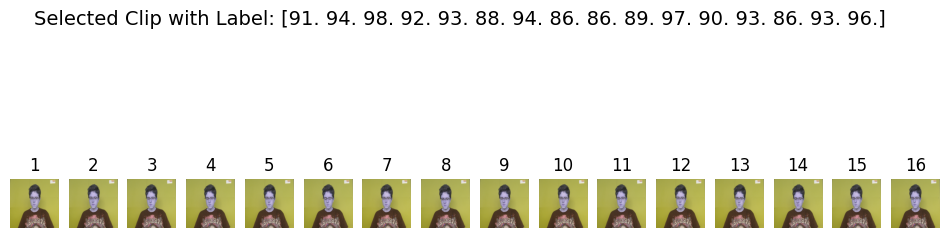

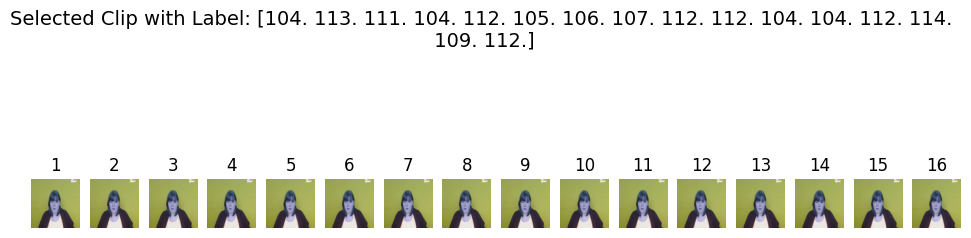

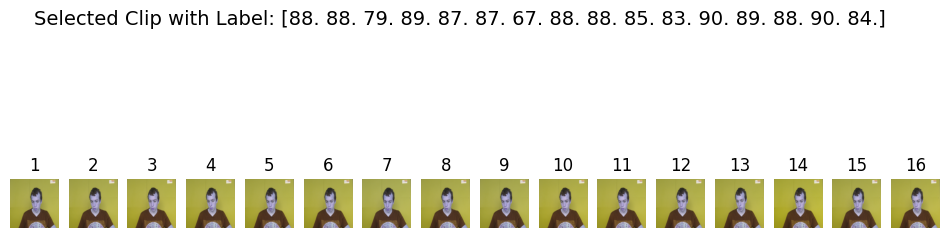

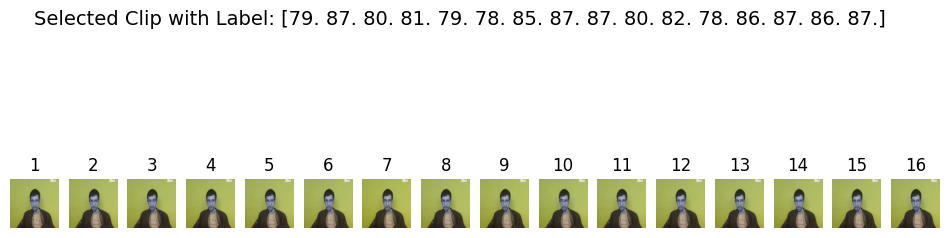

In [22]:
# Assuming you have the 'data_loader' that provides batches of video clips and labels
batch_iter = iter(data_loader)
batch = next(batch_iter)  # Load the next batch

video_clips, ground_truth_labels = batch

In [24]:
# Convert the list of video frames to a tensor
video_clips_tensor = torch.stack(video_clips)

# Reshape the video clips tensor to match the model's input
video_clips_reshaped = video_clips_tensor.view(-1, frame_length, 3, pixel_size, pixel_size)

# Set the model to evaluation mode
loaded_model.eval()

# Run inference
with torch.no_grad():
    predictions_2 = loaded_model(video_clips_reshaped)


In [1]:
# Assuming batch_size is 4 and frame_length is 16
# Plot the ground truth and predicted heart rate for each frame in the batch
batch_index = 1  # Change this index to select a different batch

plt.figure(figsize=(8, 4))

# Extract the ground truth and predicted heart rate values for the specific batch
ground_truth_batch = ground_truth_labels[batch_index].cpu().numpy()
predicted_batch = predictions_2[batch_index].cpu().numpy()

print('Avg Ground_Truth Values per Batch:', np.average(ground_truth_batch))
print('Model Prediction Value per Batch: ', predicted_batch)

for i in range(batch_size):
    plt.plot(range(frame_length), ground_truth_batch[i], label=f'Ground Truth - Video {i+1}')

    # Reshape the predicted values to match the frame_length
    # predicted_values = predicted_batch[0, i, :, 0, 0, 0]  # Assuming frames are in dimension 2
    # plt.plot(range(frame_length), predicted_values, label=f'Predicted - Video {i+1}', linestyle='dashed')

plt.xlabel('Frame')
plt.ylabel('Heart Rate')
plt.title(f'Batch {batch_index + 1}')
plt.legend()
plt.show()


NameError: ignored